# pandas-ml-qunat - The Pandas Machine Leraning and Quant Finance Library

This is the root repository of the follwoing 3 core components:

* pandas-ml-common - a more general utilities and monkey patched pandas objects provider
* pandas-ml-quant - provides technical analysis inidcators, plots, loss functions, etc.
* pandas-ml-utils - apply statistical or ml models directly to data frames

## Demonstration of all 3 libraries used together
### First import needed objects

In [25]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from pandas_ml_utils.ml.data.extraction import extract_with_post_processor
from pandas_ml_utils import FeaturesAndLabels, Model, SkModel
from pandas_ml_quant import pd, np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Next fetch some stock data and plot it

Note that:
1. all indicators and charting functionalities are behind the **q**and property attached to all pandas objects
1. the **m**achine**l**earning proptery provides access to (raw) data as it is useful/needed by statistical and ml models
1. all model relevant functionalities are behind the **model** property


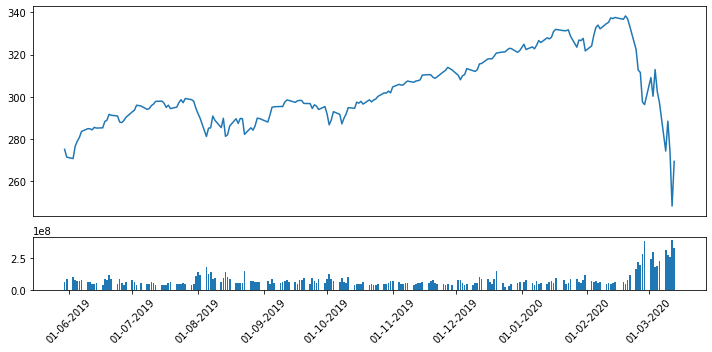

In [2]:
df = pd.fetch_yahoo("SPY")

# NOTE the access to the q_uant property
df[-200:].q.ta_plot(figsize=(10, 5))()

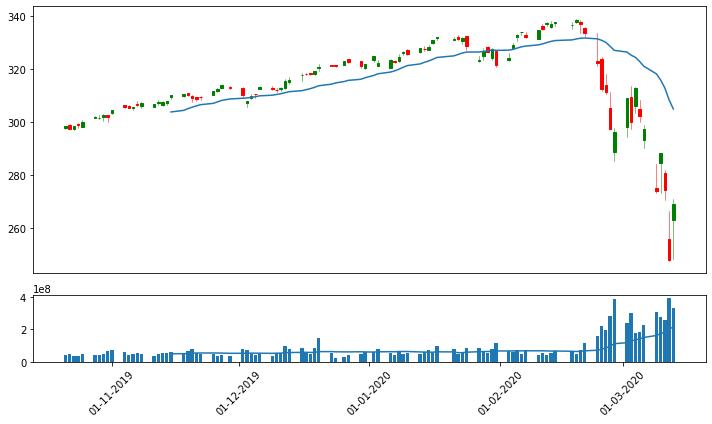

In [3]:
plt = df[-100:].q.ta_plot(figsize=(10, 6))
plt.candlestick()
plt.line(df[-100:]["Close"].q.ta_sma(period=20))
plt.bar("Volume")
plt.line(df[-100:]["Volume"].q.ta_sma(period=20), panel=1)

### Next think of a predictive model
Lets say we want to predict whether two moving averages are corssing within the next 5 days in the future or not.

In [4]:
# NOTE all technical analysis starts with the "ta_" prefix
df["Close"].q.ta_sma(period=60)\
           .q.ta_cross(df["Close"].q.ta_sma(period=20))\
           .q.ta_rnn([1,2,3,4,5])\
           .abs()\
           .sum(axis=1)\
           .shift(-5)\
           .tail(10)

Date
2020-03-02    1.0
2020-03-03    1.0
2020-03-04    1.0
2020-03-05    1.0
2020-03-06    0.0
2020-03-09    NaN
2020-03-10    NaN
2020-03-11    NaN
2020-03-12    NaN
2020-03-13    NaN
dtype: float64

And we want to predict this binary event based on a set of indicators like the RSI (Relative Strength Index) and such.

So we can build up a features and labels definition like so:

In [19]:
fnl = FeaturesAndLabels(
    features=[
        lambda df: df["Close"].q.ta_apo(),
        lambda df: df["Close"].q.ta_rsi(),
        lambda df: df["Close"].q.ta_roc(),
        lambda df: df["Close"].q.ta_trix(),
        lambda df: df["Close"].q.ta_ppo(),
        lambda df: df["Close"].pct_change().q.ta_zscore() / 4.,
        lambda df: df["Close"].q.ta_week_day(),
        lambda df: df["Close"].q.ta_week(),
        lambda df: df["Close"].q.ta_up_down_volatility_ratio(),
        lambda df: df.q.ta_adx(), 
        lambda df: df.q.ta_atr(),
        lambda df: df.q.ta_tr(),
        lambda df: df.q.ta_williams_R(),
        lambda df: df.q.ta_ultimate_osc(),
        lambda df: df.q.ta_bop(),
        lambda df: df.q.ta_cci(),
    ],
    labels=[
        lambda df: df["Close"].q.ta_sma(period=60)\
                              .q.ta_cross(df["Close"].q.ta_sma(period=20))\
                              .q.ta_rnn([1,2,3,4,5])\
                              .abs()\
                              .sum(axis=1)\
                              .shift(-5)\
                              .astype(bool)
    ]
)

# NOTE the df.ml property provides access to (raw) data as it is useful/needed by statistical models
features, labels, targets, weights = df.ml.extract(fnl)
features.describe()

  res = df.rolling(period).apply(lambda c: zscore(c, ddof=ddof)[-1])

  md = tp.rolling(period).apply(lambda x: _np.abs(x - x.mean()).sum() / period)



,"Close_apo_12,26,0",Close_rsi_14,Close_roc_10,Close_trix_30,"Close_ppo_12,26,1",Close_z_20,dow,week,std +/-,+DM,-DM,+DI,-DI,ADX,atr_14,true_range,williams_R_14,"ultimate_osc_7,14,28",bop,cci_14
count,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000,6699.000000
mean,1.002555,0.549323,0.004016,0.036944,0.002448,-0.007575,0.336841,0.513481,-0.086193,0.003161,0.003469,0.002994,0.002841,0.231586,1.489607,1.513186,0.377704,0.546816,0.035688,0.240052
std,0.015241,0.113827,0.031406,0.104855,0.010902,0.246378,0.233422,0.289121,0.196859,0.001557,0.002762,0.002434,0.002135,0.083930,0.943195,1.395087,0.301386,0.101926,0.535342,1.052523
min,0.891753,0.167987,-0.267695,-0.558651,-0.074439,-0.972346,0.000000,0.019231,-0.645974,0.000745,0.000385,0.000195,0.000205,0.076091,0.147346,0.040000,0.000000,0.213749,-1.000000,-3.522097
25%,0.995338,0.468740,-0.010814,-0.004692,-0.002280,-0.160098,0.166667,0.269231,-0.223384,0.002115,0.001728,0.001473,0.001469,0.168674,0.906715,0.750000,0.104944,0.474888,-0.418393,-0.567375
50%,1.004710,0.557265,0.006616,0.053190,0.004360,-0.008159,0.333333,0.519231,-0.099388,0.002808,0.002673,0.002294,0.002270,0.217155,1.332596,1.200000,0.306452,0.550386,0.053333,0.463479
75%,1.011822,0.634070,0.021490,0.100340,0.009253,0.153060,0.500000,0.769231,0.028459,0.003776,0.004237,0.003372,0.003374,0.278931,1.846375,1.860000,0.628261,0.621077,0.500000,1.054975
max,1.059521,0.872283,0.215963,0.248463,0.030255,0.839008,0.666667,1.019231,0.520882,0.012669,0.027597,0.015448,0.017921,0.590979,12.321587,26.680000,1.000000,0.846781,1.000000,3.215749


Since we have no idea which features are actually "good" to predict the label, we want to do some feature analysis fist.


  res = df.rolling(period).apply(lambda c: zscore(c, ddof=ddof)[-1])

  md = tp.rolling(period).apply(lambda x: _np.abs(x - x.mean()).sum() / period)



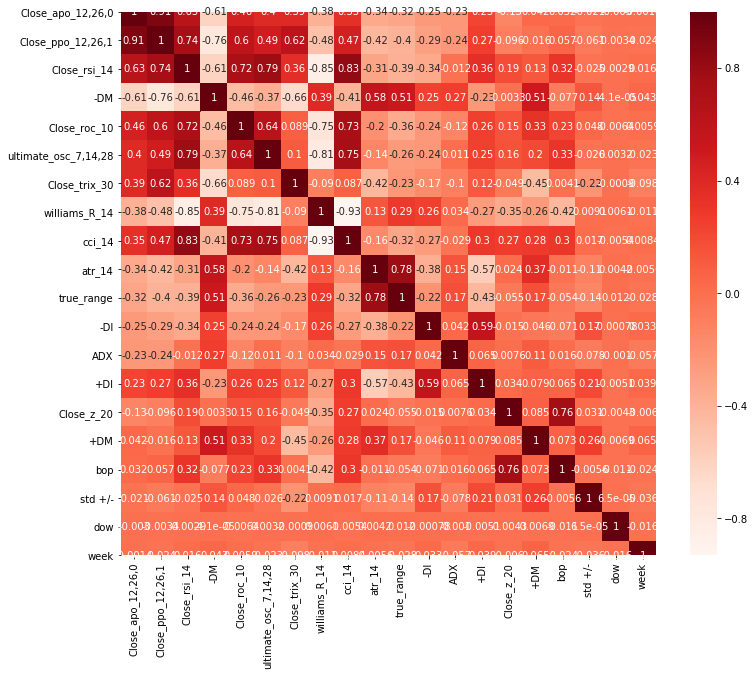

  forest.fit(x, y)



                   Close_apo_12,26,0  Close_ppo_12,26,1  Close_rsi_14  \
Close_apo_12,26,0                1.0           0.905793      0.632226   

                        -DM  Close_roc_10  ultimate_osc_7,14,28  \
Close_apo_12,26,0 -0.612291      0.461405              0.396052   

                   Close_trix_30  williams_R_14    cci_14    atr_14  \
Close_apo_12,26,0       0.393714      -0.384135  0.350735 -0.338054   

                   true_range       -DI       ADX       +DI  Close_z_20  \
Close_apo_12,26,0   -0.319703 -0.249094 -0.233386  0.229223   -0.128855   

                        +DM       bop   std +/-      dow      week  
Close_apo_12,26,0  0.041656  0.031634 -0.021053 -0.00299 -0.001417  
label is continuous: False


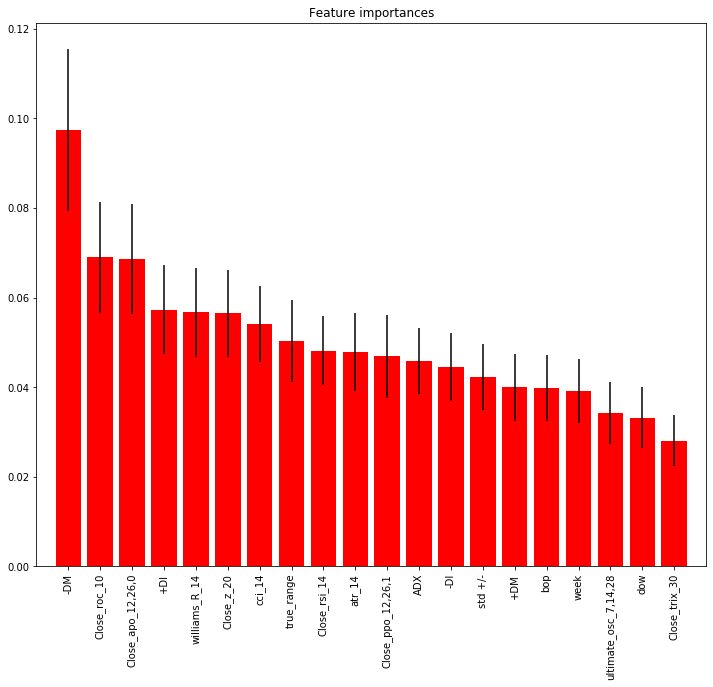

Feature ranking:
['-DM', 'Close_roc_10', 'Close_apo_12,26,0', '+DI', 'williams_R_14', 'Close_z_20', 'cci_14', 'true_range', 'Close_rsi_14', 'atr_14', 'Close_ppo_12,26,1', 'ADX', '-DI', 'std +/-', '+DM', 'bop', 'week', 'ultimate_osc_7,14,28', 'dow', 'Close_trix_30']

TOP 5 features
     -DM  Close_roc_10  Close_apo_12,26,0       +DI  williams_R_14
-DM  1.0      -0.46265          -0.612291 -0.231895       0.389658

filter feature williams_R_14 with correlation 1.0 > 0.5

filter feature Close_apo_12,26,0 with correlation 1.0 > 0.5
Features after correlation filer:
                        -DM  Close_roc_10       +DI
Close_apo_12,26,0 -0.612291      0.461405  0.229223


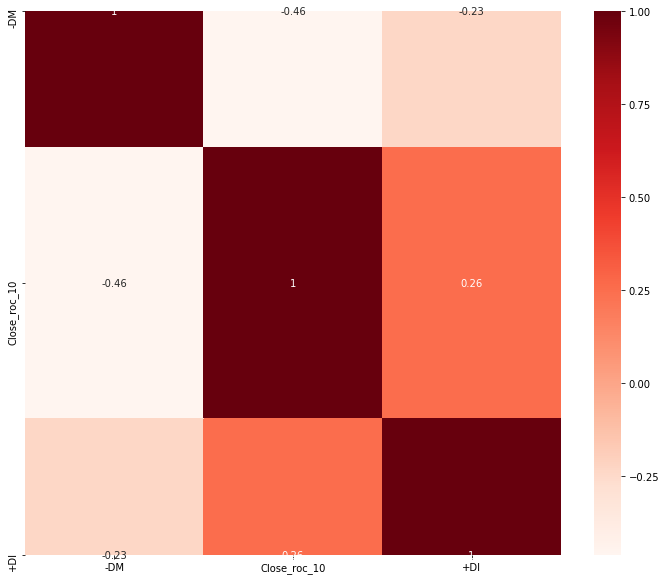

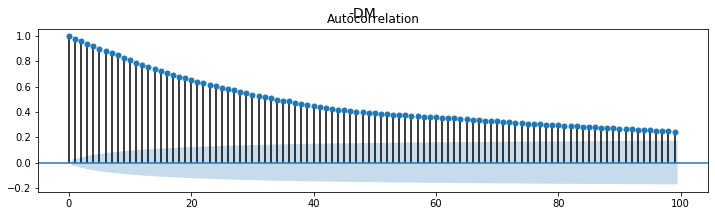

-DM      1.000000
-DM_0    1.000000
-DM_1    0.982698
-DM_2    0.963446
-DM_3    0.945545
-DM_4    0.927100
-DM_5    0.907933
-DM_6    0.889308
-DM_7    0.872031
-DM_8    0.854703
Name: -DM, dtype: float64


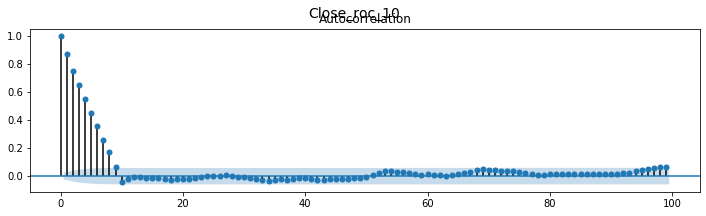

Close_roc_10      1.000000
Close_roc_10_0    1.000000
Close_roc_10_1    0.869482
Close_roc_10_2    0.752731
Close_roc_10_3    0.654011
Close_roc_10_4    0.555005
Close_roc_10_5    0.455369
Close_roc_10_6    0.358572
Close_roc_10_7    0.263227
Close_roc_10_8    0.170628
Name: Close_roc_10, dtype: float64


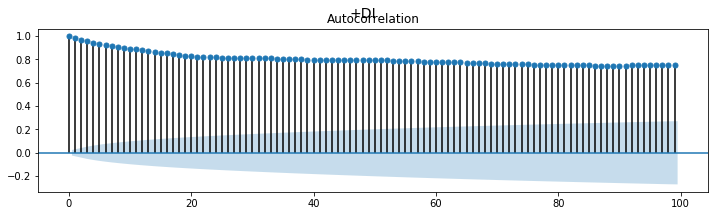

+DI      1.000000
+DI_0    1.000000
+DI_1    0.987516
+DI_2    0.971876
+DI_3    0.957592
+DI_4    0.945148
+DI_5    0.934243
+DI_6    0.925051
+DI_7    0.917617
+DI_8    0.910806
Name: +DI, dtype: float64
best lags are
[(1, '-1.00'), (2, '-0.95'), (3, '-0.90'), (4, '-0.85'), (5, '-0.81'), (6, '-0.77'), (7, '-0.72'), (8, '-0.68'), (9, '-0.65'), (10, '-0.60'), (11, '-0.56'), (12, '-0.56'), (13, '-0.55'), (14, '-0.55'), (15, '-0.54'), (16, '-0.53'), (17, '-0.52'), (18, '-0.51'), (19, '-0.51'), (20, '-0.50'), (21, '-0.50'), (22, '-0.49'), (23, '-0.49'), (24, '-0.49'), (25, '-0.49'), (26, '-0.48'), (27, '-0.48'), (28, '-0.47'), (29, '-0.47'), (30, '-0.46'), (31, '-0.46'), (32, '-0.45'), (33, '-0.45'), (34, '-0.44'), (35, '-0.43'), (36, '-0.43'), (37, '-0.43'), (38, '-0.43'), (39, '-0.43'), (40, '-0.43'), (41, '-0.42'), (42, '-0.42'), (54, '-0.42'), (55, '-0.41'), (53, '-0.41'), (43, '-0.41'), (56, '-0.41'), (45, '-0.41'), (52, '-0.41'), (44, '-0.41'), (57, '-0.41'), (46, '-0.41'), (47, '-0

In [20]:
features, lags = df.model.feature_selection(fnl)

In [21]:
features

['-DM', 'Close_roc_10', 'Close_apo_12,26,0', '+DI', 'williams_R_14']

Looks like '-DM', 'Close_roc_10', 'Close_apo_12,26,0', '+DI', 'williams_R_14' are the top 5 features to predict the label 
(which is wheter the 60 sma is crossing the20 sma withing the next 5 days or not)

So we can now build up a model from the learnings we have made.

In [26]:
fit = df.model.fit(
    SkModel(
        MLPClassifier(activation='tanh', hidden_layer_sizes=(60, 50), random_state=42),
        FeaturesAndLabels(
            features=extract_with_post_processor(
                [
                    lambda df: df["Close"].q.ta_apo(),
                    lambda df: df["Close"].q.ta_roc(),        
                    lambda df: df.q.ta_adx(), 
                ],
                lambda df: df.q.ta_rnn(lags)
            ),
            labels=[
                lambda df: df["Close"].q.ta_sma(period=60)\
                      .q.ta_cross(df["Close"].q.ta_sma(period=20))\
                      .q.ta_rnn([1,2,3,4,5])\
                      .abs()\
                      .sum(axis=1)\
                      .shift(-5)\
                      .astype(bool)

            ],
            min_required_samples=280
        ),
    )
)

fit